In [34]:
from sklearn import svm
import GPyOpt, numpy as np, seaborn as sns
%matplotlib inline

In [2]:
%run collect_and_name_data.py rnaseq

loading rnaseq data
rnaseq_all_genes: (11216, 104)
rnaseq_effector_genes: (1044, 104)
rnaseq_mod_activities: (89, 104)
rnaseq_mod_genevals: (172, 104)
rnaseq_mod_nodevals: (462, 104)
rnaseq_signaling_genes: (2184, 104)
rnaseq_design: (104, 4)


In [3]:
from paramz import Model, Param

In [19]:
def get_classification_results(true_y, pred_y):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    return pd.DataFrame([
        accuracy_score(true_y, pred_y), 
        precision_score(true_y, pred_y),
        recall_score(true_y, pred_y),
        f1_score(true_y, pred_y)
    ],['accuracy', 'precision', 'recall', 'f1'])

In [45]:
train_idx = design.Set == design.Set.unique()[0]
test_idx = ~train_idx    

train_labels = design.loc[train_idx, 'Effect']
test_labels = design.loc[test_idx, 'Effect']

test_labels_collected = test_labels.copy()
test_labels_collected[(test_labels_collected=='Effect_6')+(test_labels_collected=='Effect_7')] = 'Unknown'
#test_labels_collected = pd.get_dummies(test_labels_collected)

In [46]:
def get_train_test_set(data, train_idx, test_idx):
    train_set = data.loc[:, train_idx].copy()
    from sklearn.preprocessing import StandardScaler
    normalizer = StandardScaler()
    train_set[:] = normalizer.fit_transform(train_set.T).T

    test_set = data.loc[:, test_idx].copy()
    test_set[:] = normalizer.transform(test_set.T).T
    
    return train_set, test_set

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import StratifiedKFold

In [48]:
StratifiedKFold?

In [60]:
train_errors = {}
sk = StratifiedKFold(train_labels, 5)

for i in range(len(all_data)):
    data = all_data[i]
    train_set, test_set = get_train_test_set(data, train_idx, test_idx)
    tree = DecisionTreeClassifier()
    err = []
    for tr, te in sk:
        tree.fit(train_set.T.values[tr], train_labels.values[tr])
        prediction = tree.predict(train_set.T.values[te])
        err.append(get_classification_results(train_labels.values[te], prediction))
    train_errors[data.name] = pd.concat(err, 1).mean(1)

In [61]:
errors = pd.concat(train_errors).unstack()
errors.head()

,accuracy,precision,recall,f1
all_genes,0.736905,0.708313,0.736905,0.694059
effector_genes,0.620238,0.585298,0.620238,0.570374
mod_activities,0.520238,0.560397,0.520238,0.499467
mod_genevalues,0.578571,0.567302,0.578571,0.544246
mod_nodevalues,0.576190,0.551825,0.576190,0.537897


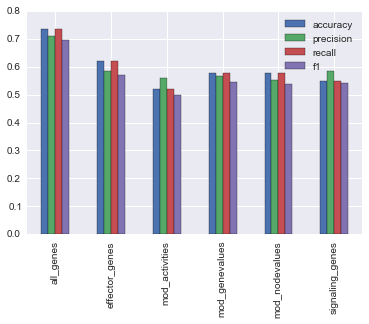

In [62]:
errors.plot(kind='bar')

In [63]:
data = all_data[0]
train_set, test_set = get_train_test_set(data, train_idx, test_idx)
tree.fit(train_set.T.values[tr], train_labels.values[tr])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [66]:
prediction_probabilities = pd.DataFrame(tree.predict_proba(test_set.T.values), index=test_set.columns, columns=tree.classes_)

In [70]:
from sklearn.metrics import classification_report
print classification_report(prediction_probabilities.idxmax(1), test_labels)

             precision    recall  f1-score   support

    Control       0.33      1.00      0.50         2
   Effect_1       0.56      0.38      0.45        13
   Effect_2       0.33      0.50      0.40         6
   Effect_3       0.00      0.00      0.00         1
   Effect_4       0.00      0.00      0.00        13
   Effect_5       0.00      0.00      0.00         7
   Effect_6       0.00      0.00      0.00         0
   Effect_7       0.00      0.00      0.00         0

avg / total       0.24      0.24      0.22        42



# Nope!